# Find the minimum risk portfolio with optimization

[*********************100%***********************]  6 of 6 completed

Restricted license - for non-production use only - expires 2026-11-23
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.3.0 24D60)

CPU model: Apple M3 Pro
Thread count: 11 physical cores, 11 logical processors, using up to 11 threads

Optimize a model with 2 rows, 6 columns and 12 nonzeros
Model fingerprint: 0xc4886a28
Model has 21 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [3e-04, 3e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-03, 1e+00]
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 12 nonzeros
Presolved model has 21 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 5
 AA' NZ     : 2.100e+01
 Factor NZ  : 2.800e+01
 Factor Ops : 1.400e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
  

[]

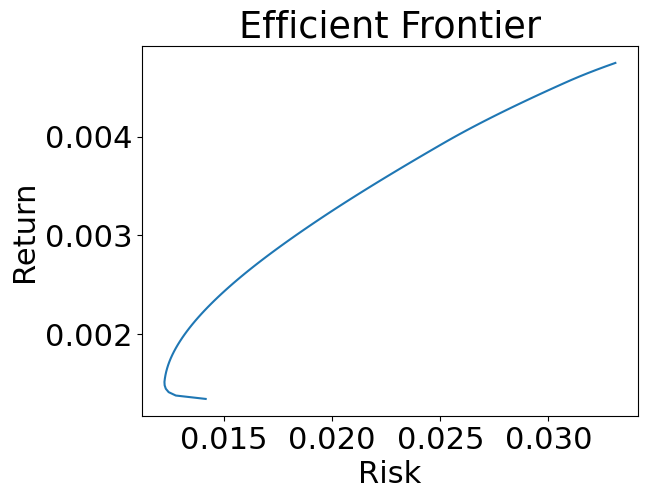

In [ ]:
import yfinance as yf
from gurobipy import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt

# setup

# gets info for each stock needed
data_stocks = yf.download(['NVDA', 'GOOG', 'AMZN', 'AAPL', 'META', 'TSLA'], start = '2024-01-01', end = '2024-12-31')

# only need closing prices - subsetting
data_stocks = data_stocks.iloc[:, 0:6]

# column names are multi-index (shows stock name and 'closing' for each) - this condenses it to just be stock name
data_stocks.columns = [f"{col[1]}" for col in data_stocks.columns]

# creating new columns for daily percent change of each stock
data_stocks['AAPL_pct_change'] = data_stocks['AAPL'].pct_change()
data_stocks['AMZN_pct_change'] = data_stocks['AMZN'].pct_change()
data_stocks['GOOG_pct_change'] = data_stocks['GOOG'].pct_change()
data_stocks['META_pct_change'] = data_stocks['META'].pct_change()
data_stocks['NVDA_pct_change'] = data_stocks['NVDA'].pct_change()
data_stocks['TSLA_pct_change'] = data_stocks['TSLA'].pct_change()

# getting rid of flat closing price columns
data_stocks.drop(['AAPL', 'AMZN', 'GOOG', 'META', 'NVDA', 'TSLA'], axis = 1, inplace = True)

# making sure index column is datetime
data_stocks.index = pd.to_datetime(data_stocks.index)

# drop first row bc it's all na's
data_stocks = data_stocks.drop(data_stocks.index[0])

# selecting stock columns in separate variable
stocks = data_stocks.columns

#%%
# model

m = Model('Portfolio optimization')

# summary stats
stock_volatility = data_stocks.std()
stock_return = data_stocks.mean()
cov_mat = data_stocks.cov()

var = pd.Series(m.addVars(stocks,lb=0), index=stocks)  
portfolio_risk = cov_mat.dot(var).dot(var)
m.setObjective(portfolio_risk, GRB.MINIMIZE)

## constraints
m.addConstr(var.sum() == 1, 'budget') 
m.addConstr(stock_return.dot(var) >= 0.0025,'return') # 0.0025 based on instructions
m.optimize()

print('Minimum Risk Portfolio:\n')
for v in var:
    if v.x > 0:
        print('\t%s\t: %g' % (v.varname, v.x))
        
# Minimum Risk Portfolio:

# 	Apple	: 0.401865
# 	Amazon	: 0.00102175
# 	Google	: 0.103756
# 	Meta	: 0.193203
# 	NVIDIA	: 0.255506
#   Tesla	: 0.0446481

returns = np.linspace(min(stock_return), max(stock_return), 100) # adjusts the axes for the graph so you can see it
ret_list = []
risks = []
props = []

for ret in returns:
    m.reset(0)
    m = Model("Portfolio_Optimization")
    m.setParam('OutputFlag', 0)
    vars=pd.Series(m.addVars(stocks,lb=0), index=stocks) 
    portfolio_risk = cov_mat.dot(vars).dot(vars)
    m.setObjective(portfolio_risk, GRB.MINIMIZE) # optimization function
    m.addConstr(vars.sum() == 1, name = 'budget' )
    m.addConstr(stock_return.dot(vars) == ret , name = 'return_sim' )
  
    m.update()
    m.optimize()  
    risks.append(np.sqrt(m.objval ) )
    ret_list.append(stock_return.dot(m.x) )
    props.append(m.x)


# efficient frontier setup
plt.rcParams.update({'font.size': 22})
plt.plot(risks, returns)
plt.xlabel('Risk')
plt.ylabel('Return')
plt.title('Efficient Frontier')
plt.plot()

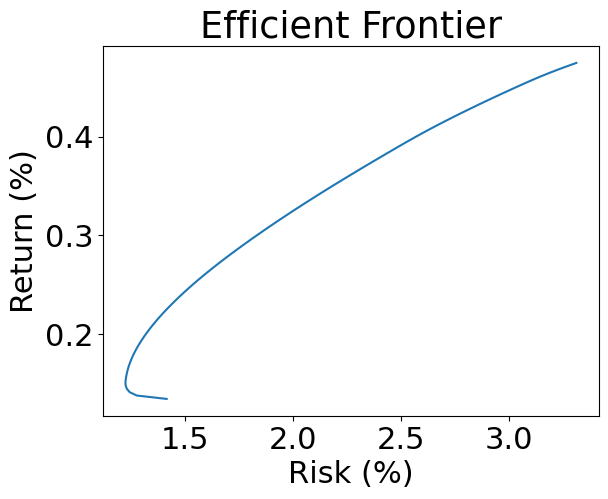

In [ ]:
# Make a better plot with %

import matplotlib.pyplot as plt

# Efficient Frontier setup
plt.rcParams.update({'font.size': 22})

# Risk & Return 값을 %로 변환
plt.plot([r * 100 for r in risks], [r * 100 for r in returns])

plt.xlabel('Risk (%)')
plt.ylabel('Return (%)')
plt.title('Efficient Frontier')
plt.show()


# Find the best sharpe ratios portfolio with optimization


🔹 Maximum Sharpe Ratio Portfolio:
    - Expected Return: 0.0030
    - Risk (Volatility): 0.0180
    - Asset Allocations:
        AAPL_pct_change: 0.3040
        AMZN_pct_change: 0.0000
        GOOG_pct_change: 0.0307
        META_pct_change: 0.2209
        NVDA_pct_change: 0.3720
        TSLA_pct_change: 0.0724


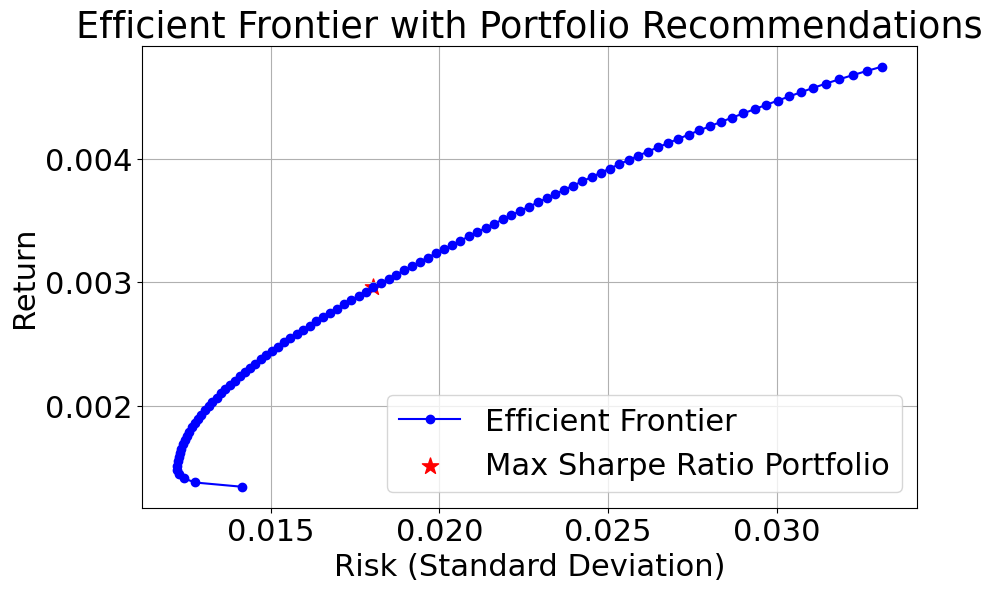

In [9]:
# Set the updated risk-free rate based on the 2-Year U.S. Treasury Yield (4.22% annual)
risk_free_rate = 0.0422 / 252  # Convert annual yield to daily rate

# Compute Sharpe Ratios
sharpe_ratios = [(ret - risk_free_rate) / risk if risk > 0 else -np.inf for ret, risk in zip(ret_list, risks)]
max_sharpe_idx = np.argmax(sharpe_ratios)  # Find the index of the maximum Sharpe Ratio

# Extract optimal values
optimal_risk = risks[max_sharpe_idx]
optimal_return = ret_list[max_sharpe_idx]
optimal_weights = props[max_sharpe_idx]

# Print Portfolio Details
print("\n🔹 Maximum Sharpe Ratio Portfolio:")
print(f"    - Expected Return: {optimal_return:.4f}")
print(f"    - Risk (Volatility): {optimal_risk:.4f}")
print("    - Asset Allocations:")
for stock, weight in zip(stocks, optimal_weights):
    print(f"        {stock}: {weight:.4f}")

# Plot Efficient Frontier with Portfolio Markers
plt.figure(figsize=(10, 6))
plt.plot(risks, ret_list, marker='o', linestyle='-', color='b', label="Efficient Frontier")
plt.scatter(optimal_risk, optimal_return, color='red', marker='*', s=150, label="Max Sharpe Ratio Portfolio")  # Mark Max Sharpe Portfolio
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Return')
plt.title('Efficient Frontier with Portfolio Recommendations')
plt.legend()
plt.grid(True)
plt.show()
